In [1]:
import pandas as pd 
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [2]:

from statsmodels.tools.sm_exceptions import  ValueWarning
import warnings

warnings.simplefilter(action = 'ignore', category = ValueWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

In [4]:
df_tea = df.loc[df['Product']=='Tea',['Date','Quantity']].reset_index(drop=True)

In [5]:
split_date = '2023-05-31'

df_train = df_tea[df_tea['Date']<= split_date]
df_test = df_tea[df_tea['Date'] > split_date]

In [6]:
results_aic = pm.auto_arima(df_train['Quantity'], trace=True, information_criterion='aic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)
results_aic = pm.auto_arima(df_train['Quantity'], trace=True, information_criterion='bic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1643.325, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1596.582, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1594.109, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1594.218, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1586.477, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1583.888, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1615.046, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1592.898, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1593.906, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1595.237, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1585.119, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1605.430, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1602.884, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1594.535, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1594.672, Time=0.27 sec
 ARIMA(3,1

In [12]:
model = ARIMA(df_train['Quantity'], order = (4,1,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  151
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -786.451
Date:                Wed, 12 Nov 2025   AIC                           1584.903
Time:                        22:42:57   BIC                           1602.967
Sample:                             0   HQIC                          1592.242
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0749      0.129      0.579      0.562      -0.179       0.328
ar.L2         -0.0034      0.110     -0.031      0.975      -0.219       0.213
ar.L3          0.0319      0.080      0.397      0.6

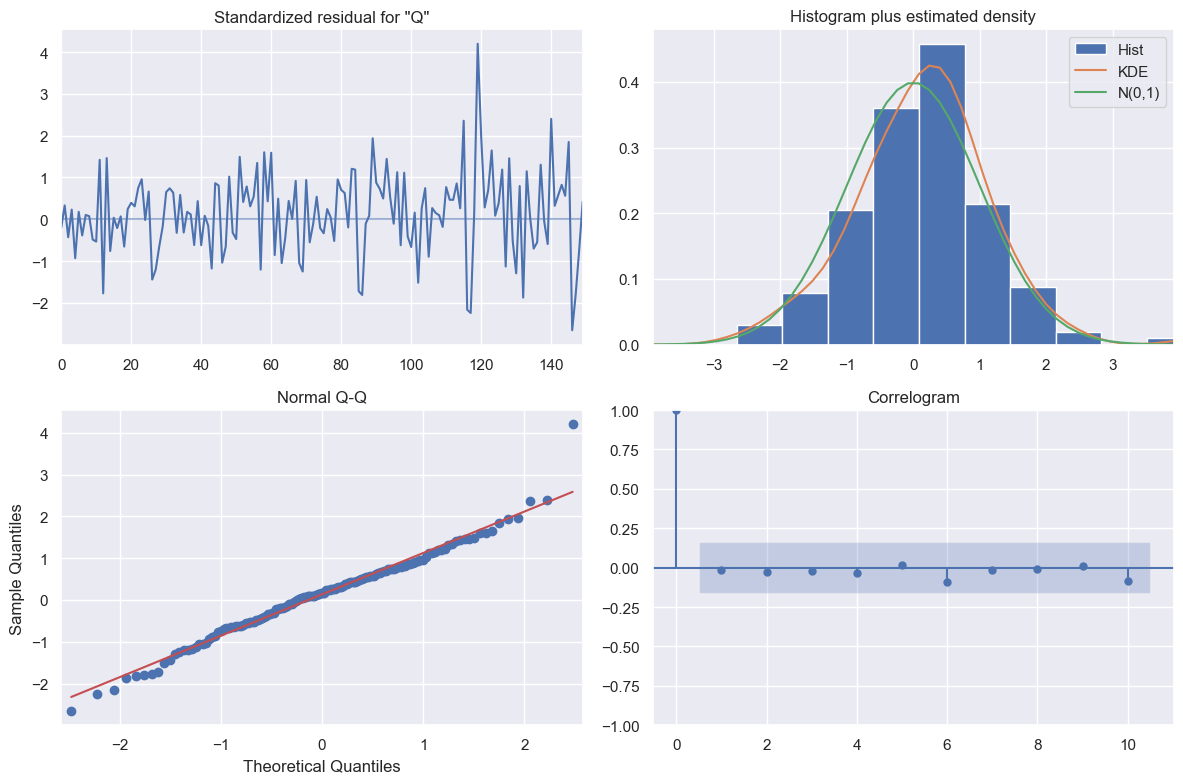

In [13]:
model.plot_diagnostics(figsize = (12,8))
plt.tight_layout()
plt.savefig('Images/Diagnostics/ARMIA_Tea.png')
plt.show()

In [14]:
forecast = model.forecast(steps=len(df_test))
forecast.index = df_test['Date']

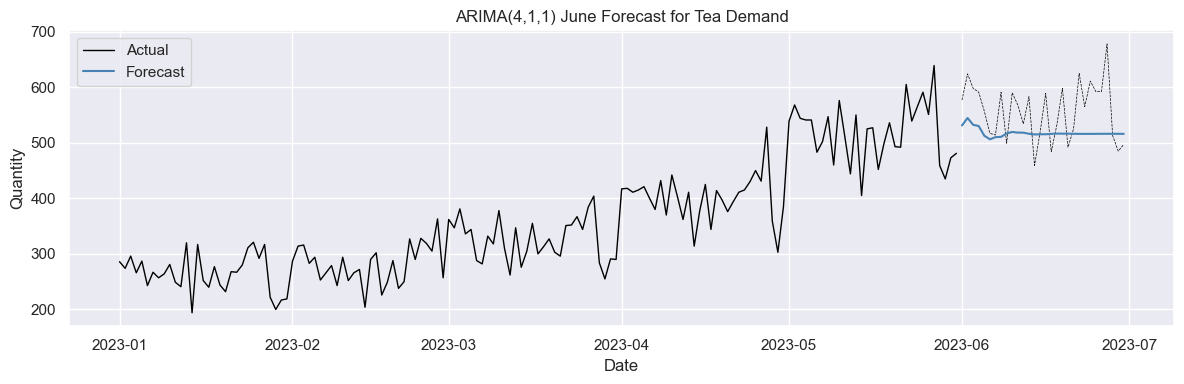

In [17]:
plt.figure(figsize=(12,4))


ax = sns.lineplot(data = df_train,x='Date',y='Quantity', label = "Actual",c='black', linewidth = 1)
ax = sns.lineplot(data = df_test,x='Date',y='Quantity', linestyle = '--', c='black', linewidth = 0.5)
ax = sns.lineplot(x=forecast.index, y=forecast, c='steelblue', label='Forecast')
ax.set(title = 'ARIMA(4,1,1) June Forecast for Tea Demand')

plt.tight_layout()
plt.savefig('Images/Forecasts/Tea_ARIMA.png')

plt.show()

In [16]:
mape = mean_absolute_percentage_error(df_test['Quantity'], forecast) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 8.74%
